In [10]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

# numbers
import numpy as np
import pandas as pd

# sc
import scanpy as sc
import anndata

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
os.chdir('/home/coakes/rat/')

In [12]:
color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
color_dict = {}

for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Label Correction

In [4]:
adata = anndata.read_h5ad(f"rat_genes_meta.h5ad")
adata = adata[~adata.obs.outlier]
adata.obs['old_tissue'] = adata.obs['tissue']
adata.obs['tissue'][adata.obs.barcode == 'SRR25251484'] = 'HYPOTH'
adata.obs['tissue'][adata.obs.barcode == 'SRR25251568'] = 'HIPPOC'
toss = ['SRR25251685', 'SRR25251610', 'SRR25251278']
adata = adata[[x not in toss for x in adata.obs.barcode],:]
adata.write('omics_adata/rat_RNA_meta.h5ad')
adata

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_1969728/2597519730.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['old_tissue'] = adata.obs['tissue']
/tmp/ipykernel_1969728/2597519730.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "c

View of AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced'

# Normalize and Subset to Highly Variable

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number


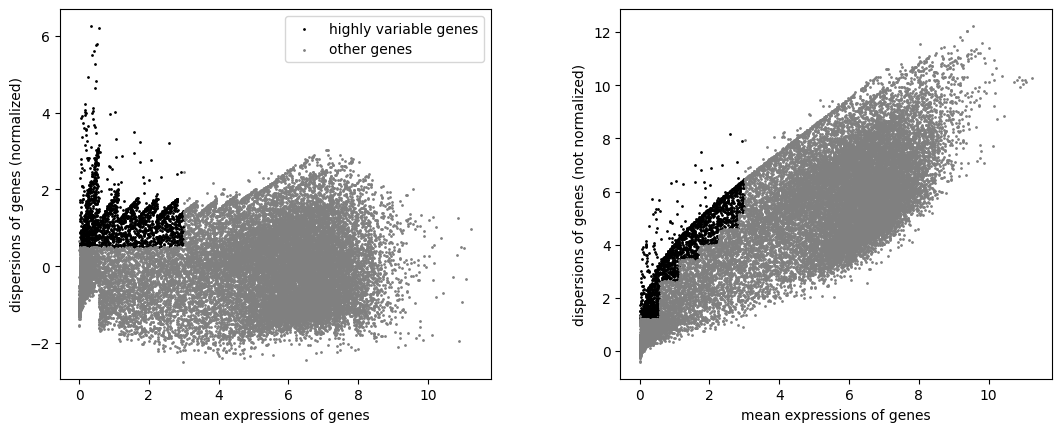

In [5]:
pre_norm_adata = adata.copy()
sc.pp.filter_genes(adata, min_counts=1)
adata.var_names_make_unique()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

# Plot PCA

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


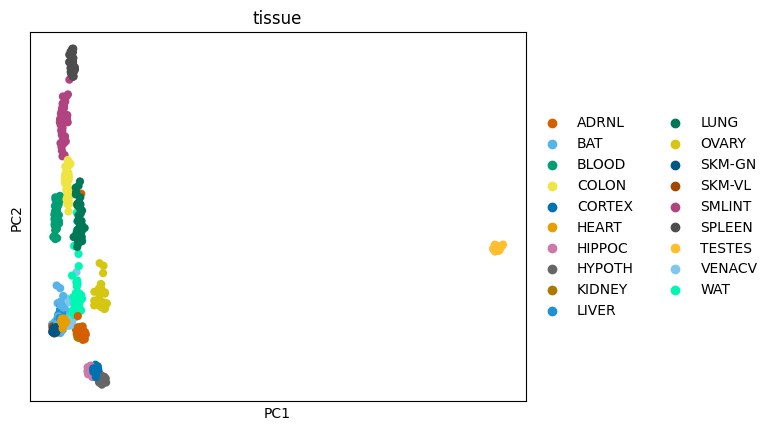

In [6]:
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)
sc.pl.pca(adata, color='tissue', palette = color_dict, ncols=2,wspace=0.5,
    save = f'_post_correction.png'
         )

# Correct and Annotate Transcript Level Data

In [29]:
transcript_adata = anndata.read_h5ad(f"rat_transcripts.h5ad")
transcript_adata

AnnData object with n_obs × n_vars = 879 × 72032
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train'
    var: 'gene_id', 'has_U_tr', 'eff_len'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [30]:
gene_meta = pd.read_csv('t2go.csv')
adata.var = pd.merge(adata.var.reset_index(), gene_meta, left_on= 'gene_id', right_on='ensembl_transcript_id', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').set_index('index')
adata.var = adata.var.drop(['X4'], axis=1)
adata.var.head()

,gene_id,has_U_tr,eff_len,mt,ensembl_transcript_id,description,ensembl_gene_id,X3,X5,X6,X7,X8,n_counts,highly_variable,means,dispersions,dispersions_norm
index,,,,,,,,,,,,,,,,,
ENSRNOG00000000009,ENSRNOG00000000009,True,1198.722637,False,ENSRNOG00000000009,NA,ENSRNOG00000000009,Tmco5b,3,100064979,100083289,+,20807.0,True,2.737382,6.003363,1.564241
ENSRNOG00000000199,ENSRNOG00000000199,True,533.001304,False,ENSRNOG00000000199,RNA binding,ENSRNOG00000000199,RGD1559995,8,79215362,79216570,-,2435.0,True,1.126189,2.996884,0.836367
ENSRNOG00000000282,ENSRNOG00000000282,True,948.628772,False,ENSRNOG00000000282,"DNA-binding transcription factor activity, RNA...",ENSRNOG00000000282,Gsc2,11,83072138,83074126,+,9480.0,True,2.022644,5.220851,1.458259
ENSRNOG00000000376,ENSRNOG00000000376,False,80.156195,False,ENSRNOG00000000376,NA,ENSRNOG00000000376,LOC108349010,20,25051477,25051701,+,10.0,True,0.030989,1.863414,1.331804
ENSRNOG00000000507,ENSRNOG00000000507,True,1583.416956,False,ENSRNOG00000000507,"NA, photoreceptor outer segment, retina homeos...",ENSRNOG00000000507,Tulp1,20,6412171,6424073,-,4579.0,True,1.706284,5.184159,1.429489


In [31]:
transcript_adata.obs = pd.merge(transcript_adata.obs.reset_index(), adata.obs, left_on= 'barcode', right_on='barcode', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').set_index('index').drop(['outlier'],axis=1)
transcript_adata = transcript_adata[~transcript_adata.obs.nid.isna()]
transcript_adata.obs.tissue = transcript_adata.obs.tissue.str.upper()
transcript_adata.obs.original_out = transcript_adata.obs.original_out.astype('bool')
transcript_adata.write('omics_adata/rat_transcript_meta.h5ad')
transcript_adata

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 861 × 72032
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'rank', 'nid', 'num_umi', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced'